# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
sys.path.append("..")
import tarfile
import tensorflow as tf
import zipfile
from object_detection.eval_util import evaluate_detection_results_pascal_voc

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2
# This is needed since the notebook is stored in the object_detection folder.

from utils import label_map_util

from utils import visualization_utils as vis_util

## Object detection imports
Here are the imports from the object detection module.

In [2]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [5]:
# What model to download.
#MODEL_NAME = 'kitti_frozen'
# atrous_train_check
# Path tofrozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'kitti_mobilenet_frozen/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'kitti_map.pbtxt')

NUM_CLASSES = 9

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
PATH_TO_LABELS = os.path.join('data', 'kitti_map.pbtxt')
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, 
                                                            max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [8]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [9]:
with open('kitti_data/train.txt') as f:
    train_ids = f.readlines()[0].split(',')
with open('kitti_data/valid.txt') as f:
    valid_ids = f.readlines()[0].split(',')

In [10]:
len(train_ids)

6732

In [11]:
len(valid_ids)

749

# Detection

In [12]:
PATH_TO_TEST_IMAGES_DIR = 'voc_kitti_valid/VOC2012/JPEGImages/'
p = 'voc_kitti_valid/VOC2012/JPEGImages/1023.jpg'
TEST_IMAGE_PATHS = [ p]
FIGSIZE = (20, 20)

In [13]:
import glob
def glob_base(pat): return list(map(os.path.basename, glob.glob(pat)))

In [14]:
glob_base('voc_kitti/VOC2012/JPEGImages/*.jpg')[0]

'5393.jpg'

In [15]:
from create_dataset import *

In [16]:
valid_ids = glob_base(VOC_VALID_DIR + '/VOC2012/JPEGImages/*.jpg')
train_ids = glob_base(VOC_TRAIN_DIR+ '/VOC2012/JPEGImages/*.jpg')

len(pd.Index(valid_ids).intersection(train_ids))

0

In [ ]:
#glob_base('voc_kitti_valid/VOC2012/JPEGImages/*.jpg')[0]

### Hack to overcome not deleting voc_kitti_valid

In [23]:
def glob_base(pat): return list(map(os.path.basename, glob.glob(pat)))
assert len(pd.Index(
   glob_base('voc_kitti_valid/VOC2012/JPEGImages/*.jpg')
).difference(glob_base('voc_kitti/VOC2012/JPEGImages/*.jpg'))) < 750

In [24]:
test_dir = 'voc_kitti_valid/VOC2012/JPEGImages/'
test_image_paths = [os.path.join(test_dir, x) for x in valid_ids]

In [25]:
len(test_image_paths)

749

In [26]:
from utils.np_box_list import BoxList

In [27]:
#image_path = paths[0]

In [28]:
from create_dataset import xml_to_dict

In [18]:
def get_annotations(image_path):
    img_id = os.path.basename(image_path)[:-4]
    annotation_path = os.path.join(
    os.path.split(os.path.dirname(image_path))[0], 'Annotations',
    '{}.xml'.format(img_id)
    )
    return xml_to_dict(annotation_path)

In [19]:
#data = get_annotations(image_path)

In [20]:
from utils.kitti import show_groundtruth, create_results_list

In [ ]:
!wc kitti_data/train.txt.txt

In [ ]:
ls kitti_data/valid/image_2/ | wc

In [ ]:
train_labs= glob.glob('kitti_data/training/label_2/*.txt')
test_labs = glob.glob('kitti_data/valid/label_2/*.txt')

In [ ]:
len(test_labs)

In [ ]:
len(train_labs)

In [ ]:
lns

In [ ]:
# n/A 80%
# also wrong enough that maybe a bug?

In [30]:
from utils.kitti import visualize_predictions

In [ ]:
len(test_image_paths)

In [ ]:
#len(test_image_paths)

In [29]:
%%time
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        res = create_results_list(test_image_paths, sess, detection_graph)

CPU times: user 3min 18s, sys: 12.3 s, total: 3min 30s
Wall time: 3min 22s


In [ ]:
def get_dict_slice(res, slc_obj):
    output = {}
    for k in res.keys():
        output[k] = res[k][slc_obj]
    return output
        
        

In [ ]:
img_scores = {i: evaluate_detection_results_pascal_voc(
    get_dict_slice(res, slice(i, i+1)), categories)
              for i in range(len(res['image_id'])-1)}
                                           
                                           

In [31]:
import pandas as pd
perf = pd.Series(evaluate_detection_results_pascal_voc(res, categories))

../object_detection/utils/metrics.py:145: RuntimeWarning: invalid value encountered in true_divide
  num_images_correctly_detected_per_class / num_gt_imgs_per_class)


In [ ]:
OVERALL_PERF_KEY = 'Precision/mAP@0.5IOU'

In [43]:
rcnn_valid = pd.read_csv('run_rcnn-.-tag-TotalLoss.csv')
ssd_valid = pd.read_csv('run_ssd-.-tag-TotalLoss.csv')

In [45]:
rcnn_valid.shape

(1000, 3)

In [57]:
ssd_valid['time_since'] =  ssd_valid['Wall time'] - ssd_valid['Wall time'].iloc[0]
rcnn_valid['time_since'] =  rcnn_valid['Wall time'] - rcnn_valid['Wall time'].iloc[0]

In [58]:
ssd_valid.head()

,Wall time,Step,Value,time_since
0,1.508733e+09,1706,5.231366,0.000000
1,1.508734e+09,5195,3.909429,1199.965234
2,1.508734e+09,6255,4.324656,1559.989364
3,1.508735e+09,8389,4.341696,2279.847728
4,1.508737e+09,14068,4.128845,4199.973650


In [71]:
ssd_valid.iloc[-1].loc[['time_since', 'Value', 'Step']]
                        

time_since    4.575601e+05
Value         2.778544e+00
Step          1.327123e+06
Name: 999, dtype: float64

In [72]:
rcnn_valid.iloc[-1].loc[['time_since', 'Value', 'Step']]
                        

time_since    155879.868040
Value              0.474066
Step          179116.000000
Name: 999, dtype: float64

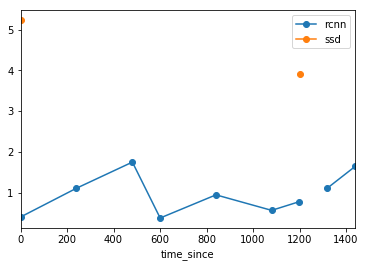

In [78]:
pd.concat([
    rcnn_valid.set_index('time_since').Value.to_frame('rcnn'),
    ssd_valid.set_index('time_since').Value.to_frame('ssd')],
    axis=1)
    
    

In [65]:
(ssd_valid.Step / ssd_valid.time_since).iloc[-1]

2.9004344516490357

In [64]:
(rcnn_valid.Step / rcnn_valid.time_since).iloc[-1]

1.149064354827013

In [39]:
!mv /home/shleifer/Downloads/run_ssd-.-tag-TotalLoss.csv .

In [41]:
#ls

In [ ]:
import pickle

In [ ]:
pickle.dump(res, open('mobile_net_valid_results_dct.pkl', 'wb'))

In [ ]:
#re2 = pickle.load(open('valid_results_dct.pkl', 'rb'))

In [ ]:
del re2

In [ ]:
categories

In [ ]:
[idx for idx, i in enumerate(res['groundtruth_classes']) if 4 in i][:3]

In [ ]:
res['image_id'][0]

In [ ]:
#Image(test_image_paths[0]

In [ ]:
import pandas as pd
pd.Series(evaluate_detection_results_pascal_voc(res, categories))

In [ ]:
len(test_image_paths)

In [ ]:
320/ 7491

In [ ]:
image = Image.open(image_path)
plt.figure(figsize=FIGSIZE)
plt.imshow(image)

In [ ]:
from kitti_constants import name_to_id

In [ ]:
from object_detection.utils.visualization_utils import visualize_boxes_and_labels_on_image_array

In [ ]:
box_mat.shape

In [ ]:
classes.ndim

In [ ]:
visualize_boxes_and_labels_on_image_array(
    image_np,
    box_mat,
    classes.astype(np.int32),
    scores,
    category_index,
    use_normalized_coordinates=True,
    line_thickness=8)

In [ ]:
plt.imshow(plt.imread('worst_prediction.jpg'))

In [ ]:
pd.DataFrame(img_scores).T.sort_values(OVERALL_PERF_KEY).iloc[0]

In [ ]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # image_path = np.random.choice(test_image_paths)
        image_path = test_image_paths[650]
        image = Image.open(image_path)
        image_np = load_image_into_numpy_array(image)
        boxes, scores, classes, num_detections = get_boxes_scores_classes(image_np, sess, detection_graph)
        image_process = detect_objects(image_np, sess, detection_graph)
        # [x['name'] for x in data['object']]
        plt.figure(figsize=FIGSIZE)
        plt.imshow(image_process)
        plt.title('Model', fontsize=16)
        #plt.imsave(image_process, 'worst_prediction labs.jpg')
        plt.figure(figsize=FIGSIZE)
        truth_img = show_groundtruth(image_path)
        plt.imshow(truth_img)
        plt.title('Human Labels', fontsize=16)
        plt.figure(figsize=FIGSIZE)
        plt.imshow(load_image_into_numpy_array(Image.open(image_path)))
        plt.title('Raw Image')
        #plt.savefig('worst_prediction labs.jpg')

In [ ]:
label_paths = glob.glob(os.path.join('kitti_data', '*','label_2', '*.txt'))

In [ ]:

#label_paths

In [ ]:
for path in label_paths:
    strip_leading_zeroes(path)

In [ ]:
from_kitti = {'image': {'path': 'kitti_data/training/image_2/2456.jpg', 'height': 370, 'segmented_path': None, 'id': '2456', 'width': 1224}, 'detections': [{'top': 136.7, 'left': 275.0, 'right': 353.9, 'bottom': 299.54, 'label': 'person'}]}

In [ ]:
from create_pascal_tf_record import kitti_dict_to_tf_example

In [ ]:
kitti_dict_to_tf_example(from_kitti)

In [ ]:
#create_records()

### Kitti Port

In [ ]:
import glob
images = glob.glob('/Users/shleifer/kitti_trunc/training/image_2/*')


In [ ]:
labels = glob.glob('/Users/shleifer/kitti_trunc/training/label_2/*')

In [ ]:
dets = glob.glob('/Users/shleifer/kitti_trunc/training/det_2/*')

In [ ]:
orig_image_paths = glob.glob('/Users/shleifer/kitti_data/training/image_2/*.png')

In [ ]:
from create_dataset import convert_to_jpg_and_save
%load_ext autoreload
%autoreload 2

In [ ]:
def convert_to_jpg_and_save(png_path):
    im = Image.open(png_path)
    rgb_im = im.convert('RGB')
    new_path = '{}.jpg'.format(png_path[:-4])
    rgb_im.save(new_path)
    return new_path
Image.open(convert_to_jpg_and_save(orig_image_paths[0]))

In [ ]:
import shutil

In [ ]:
import pandas as pd
pd.value_counts(list(map(lambda x: len(os.path.basename(x)),images)))

In [ ]:
Image.open(images[0])

In [ ]:
root_dir = '/Users/shleifer/voc_kitti/VOC2012/'
img_dir = os.path.join(root_dir, 'JPEGImages')
ann_dir = os.path.join(root_dir, 'Annotations')
set_dir = os.path.join(root_dir, 'ImageSets', 'Main')

In [ ]:
labels = glob.glob('/Users/shleifer/kitti_trunc/training/label_2/*')

In [ ]:
xml_p = glob.glob('/Users/shleifer/voc_kitti/VOC2012/Annotations/1023.xml')[0]

In [ ]:
voc_annot = tf.gfile.GFile(xml_p, 'r').read()

In [ ]:
%load_ext autoreload
%autoreload 2
from create_pascal_tf_record import dict_to_tf_example

In [ ]:
import sys; sys.path.append('..')

In [ ]:
from object_detection.create_pascal_tf_record import dict_to_tf_example

In [ ]:
dataset_directory =  '/Users/shleifer/voc_kitti/'
image_subdirectory='JPEGImages'

In [ ]:
from object_detection.utils import dataset_util
from object_detection.utils import label_map_util
import hashlib
import io
import logging
import os

from lxml import etree
import PIL.Image
import tensorflow as tf


writer = tf.python_io.TFRecordWriter('data/train.tfrecord')
label_map_dict = label_map_util.get_label_map_dict('data/my_map.pbtxt')
annotations_dir = '/Users/shleifer/voc_kitti/VOC2012/Annotations/'
examples_path = '/Users/shleifer/voc_kitti/VOC2012/ImageSets/Main/trainval.txt'


examples_path = '/Users/shleifer/voc_kitti/VOC2012/ImageSets/Main/trainval.txt'

#examples_list

def create_records(examples_path):
    examples_list = dataset_util.read_examples_list(examples_path)
    for example in examples_list[1:11]:
        path = os.path.join(annotations_dir, example + '.xml')
        #print(path)
        with tf.gfile.GFile(path, 'r') as fid:
            xml_str = fid.read()
        xml = etree.fromstring(xml_str)
        data = dataset_util.recursive_parse_xml_to_dict(xml)['annotation']
        tf_example = dict_to_tf_example(data, 
                                        dataset_directory,
                                        label_map_dict,
                                        False)
        writer.write(tf_example.SerializeToString())
    writer.close()

In [ ]:
create_records(examples_path)

In [ ]:
data['folder']

In [ ]:
os.path.join('/Users/shleifer/voc_kitti/VOC2012/JPEGImages/')

In [ ]:
data['filename']

In [ ]:
f = 'data/train.tfrecord'
for serialized_example in tf.python_i o.tf_record_iterator(f):
    example = tf.train.Example()
    example.ParseFromString(serialized_example)
    print(example)
    break

    # Read data in specified format
    label = example.features.feature["image/object/class/label"].float_list.value
    ids = example.features.feature["ids"].int64_list.value
    values = example.features.feature["values"].float_list.value
    print(label, id, values)

In [ ]:
example.features.feature.keys()

In [ ]:
Image.open('/Users/shleifer/voc_kitti/VOC2012/JPEGImages/5308.jpg')

In [ ]:
ls data/train.tfrecord

In [ ]:
#examples_list

In [ ]:
label_map_dict

In [ ]:
data['object']

In [ ]:
#full_path

In [ ]:
  with tf.gfile.GFile(full_path, 'rb') as fid:
    encoded_jpg = fid.read()

In [ ]:
import io
encoded_jpg

In [ ]:
from cv2 import imread

In [ ]:
import io

In [ ]:
img_path = os.path.join(data['folder'], image_subdirectory, data['filename'])
full_path = os.path.join(dataset_directory, img_path)

In [ ]:
data['folder']

In [ ]:
/Users/shleifer/voc_kitti/VOC2012/JPEGImages/

In [ ]:
data

In [ ]:
dict_to_tf_example()

In [ ]:
examples_path = '~/sh'

In [ ]:
ls data

In [ ]:
!cat {labels[0]}

In [ ]:
# list image sets
all_files = !ls {set_dir}
image_sets = sorted(list(set([filename.replace('.txt', '').strip().split('_')[0] for filename in all_files])))
image_sets

In [ ]:
ann_dir